In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score , mean_squared_error, confusion_matrix
from collections import Counter

In [ ]:
# Load the dataset
df = pd.read_csv('Infected_Data.csv')

print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,ID,Fever,Cough,Breathing Issues,Infected
0,1,N,N,N,N
1,2,Y,Y,Y,Y
2,3,Y,Y,N,N
3,4,Y,N,Y,Y
4,5,Y,Y,Y,Y


In [ ]:
# Get information about the dataset
print("Dataset information:")
df.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                14 non-null     int64 
 1   Fever             14 non-null     object
 2   Cough             14 non-null     object
 3   Breathing Issues  14 non-null     object
 4   Infected          14 non-null     object
dtypes: int64(1), object(4)
memory usage: 692.0+ bytes


In [ ]:
# Get the value counts of the target column 'Infected'
print("Value counts of the 'Infected' column:")
display(df['Infected'].value_counts())

Value counts of the 'Infected' column:


,count
Infected,
Y,8
N,6


In [ ]:
# Separate features (X) and target (y)
X = df.drop(columns=["ID", "Infected"])
y = df["Infected"]

In [ ]:
from collections import Counter

# Entropy Function: Calculates the entropy of a given set of labels.
def entropy(y, node_name="Root"):
    counts = Counter(y) # Count the occurrences of each unique label in y
    probabilities = [count / len(y) for count in counts.values()] # Calculate the probability of each label
    ent = -sum(p * np.log2(p) for p in probabilities if p > 0) # Calculate entropy using the formula
    print(f"Entropy at node '{node_name}': {round(ent, 4)} (Samples={len(y)}, Classes={dict(counts)})") # Print entropy information
    return ent

# Information Gain: Calculates the information gain of splitting on a given feature.
def information_gain(y, X_column):
    parent_entropy = entropy(y, node_name="Parent") # Calculate entropy of the parent node
    values = np.unique(X_column) # Get unique values in the feature column
    weighted_entropy = 0
    for val in values:
        y_subset = y[X_column == val] # Get the subset of target labels for each unique value
        weighted_entropy += (len(y_subset) / len(y)) * entropy(y_subset, node_name=f"Child={val}") # Calculate weighted entropy of child nodes
    return parent_entropy - weighted_entropy # Return information gain

# Best Feature Selection: Finds the best feature to split on based on information gain.
def best_split(X, y):
    best_gain, best_feature = -1, None # Initialize best gain and feature
    gains = {} # Dictionary to store information gains
    for feature in X.columns: # Iterate through each feature
        gain = information_gain(y, X[feature]) # Calculate information gain for the feature
        gains[feature] = gain # Store the information gain
        print(f"IG({feature}) = {round(gain, 4)}") # Print information gain for the feature
        if gain > best_gain: # Check if current gain is better than the best gain
            best_gain, best_feature = gain, feature # Update best gain and feature
    return best_feature, best_gain, gains # Return the best feature, its gain, and all gains

# Build Tree Recursively: Builds the decision tree recursively.
def build_tree(X, y, depth=0, parent="Root"):
    print("\n") # Print a newline for better readability
    print(f"Depth {depth} | Parent Node: {parent}") # Print current depth and parent node
    ent = entropy(y, node_name=parent) # Calculate entropy at the current node

    # Stop criteria: pure node or no features left
    if len(set(y)) == 1 or X.shape[1] == 0:
        print(f"Leaf Node --> Class: {Counter(y).most_common(1)[0][0]}") # Print leaf node class
        return

    # Find best feature to split
    feature, gain, _ = best_split(X, y)
    if feature is None or gain == 0:
        majority_class = Counter(y).most_common(1)[0][0] # Get the majority class
        print(f"Leaf Node --> No useful split. Class: {majority_class}") # Print leaf node class if no useful split
        return

    print(f"Best Feature to Split: {feature} (IG={round(gain,4)})") # Print the best feature to split on

    # Recursively build tree for each branch of the chosen feature
    for val in X[feature].unique(): # Iterate through unique values of the best feature
        mask = X[feature] == val # Create a mask for the current value
        print(f"\n--> Splitting on {feature} = {val}") # Print splitting information
        build_tree(X[mask].drop(columns=[feature]), y[mask], depth+1, parent=f"{feature}={val}") # Recursively call build_tree

# Build the decision tree
build_tree(X, y)



Depth 0 | Parent Node: Root
Entropy at node 'Root': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.9183 (Samples=6, Classes={'N': 4, 'Y': 2})
Entropy at node 'Child=Y': 0.8113 (Samples=8, Classes={'Y': 6, 'N': 2})
IG(Fever) = 0.1281
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.8113 (Samples=4, Classes={'N': 1, 'Y': 3})
Entropy at node 'Child=Y': 1.0 (Samples=10, Classes={'Y': 5, 'N': 5})
IG(Cough) = 0.0391
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.65 (Samples=6, Classes={'N': 5, 'Y': 1})
Entropy at node 'Child=Y': 0.5436 (Samples=8, Classes={'Y': 7, 'N': 1})
IG(Breathing Issues) = 0.396
Best Feature to Split: Breathing Issues (IG=0.396)

--> Splitting on Breathing Issues = N


Depth 1 | Parent Node: Breathing Issues=N
Entropy at node 'Breathing Issues=N': 0.65 (Samples=6, 

Entropy at node 'Root': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.9183 (Samples=6, Classes={'N': 4, 'Y': 2})
Entropy at node 'Child=Y': 0.8113 (Samples=8, Classes={'Y': 6, 'N': 2})
IG(Fever) = 0.1281
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.8113 (Samples=4, Classes={'N': 1, 'Y': 3})
Entropy at node 'Child=Y': 1.0 (Samples=10, Classes={'Y': 5, 'N': 5})
IG(Cough) = 0.0391
Entropy at node 'Parent': 0.9852 (Samples=14, Classes={'N': 6, 'Y': 8})
Entropy at node 'Child=N': 0.65 (Samples=6, Classes={'N': 5, 'Y': 1})
Entropy at node 'Child=Y': 0.5436 (Samples=8, Classes={'Y': 7, 'N': 1})
IG(Breathing Issues) = 0.396
Entropy at node 'Root': 0.65 (Samples=6, Classes={'N': 5, 'Y': 1})
Entropy at node 'Parent': 0.65 (Samples=6, Classes={'N': 5, 'Y': 1})
Entropy at node 'Child=N': -0.0 (Samples=3, Classes={'N': 3})
Entropy at node 'Chil

<Figure size 1200x700 with 0 Axes>

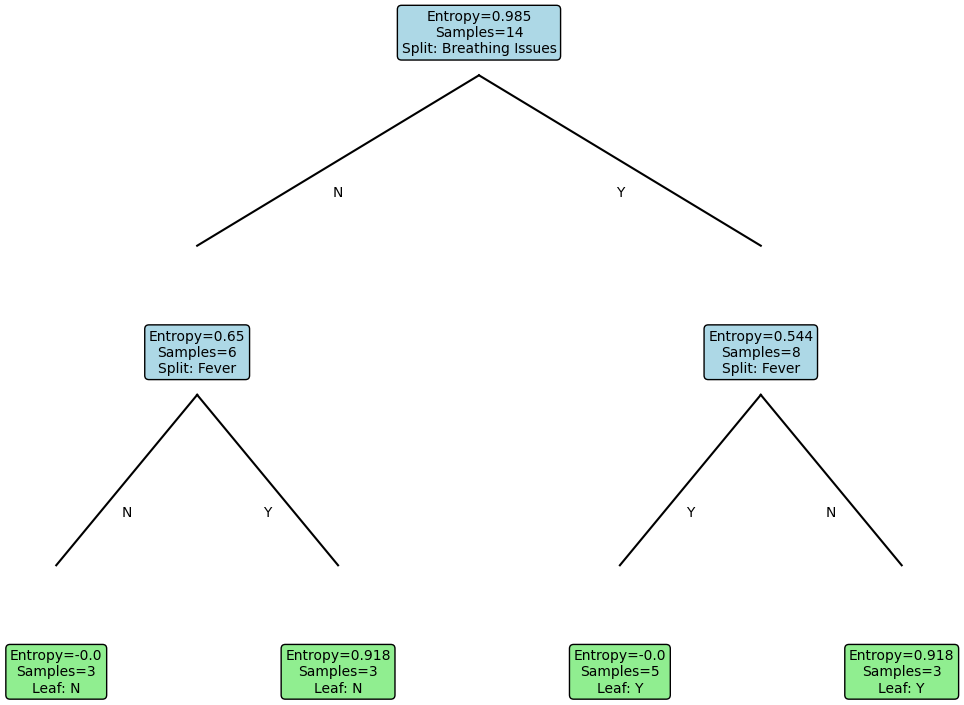

In [ ]:
# Plotting the tree
def plot_tree(node_X, node_y, x=0.5, y=1, dx=0.25, dy=0.15, depth=0, ax=None):
    if ax is None:
        # Create a new figure and axes if none is provided
        fig, ax = plt.subplots(figsize=(12,7))
        ax.set_axis_off() # Turn off axes

    # Calculate entropy for the current node
    node_entropy = round(entropy(node_y), 3)
    label = f"Entropy={node_entropy}\nSamples={len(node_y)}"

    # If the node is pure or no features are left, it's a leaf node
    if len(set(node_y)) == 1 or node_X.shape[1] == 0:
        leaf_class = Counter(node_y).most_common(1)[0][0] # Determine the majority class
        # Add text annotation for the leaf node
        ax.text(x, y, f"{label}\nLeaf: {leaf_class}", ha="center", va="center",
                bbox=dict(boxstyle="round", facecolor="lightgreen"))
        return ax # Return the axes

    # Find the best feature to split on (greedy approach)
    feature, gain, _ = best_split(node_X, node_y)

    # If no useful split is found, it's a leaf node
    if feature is None or gain == 0:
        leaf_class = Counter(node_y).most_common(1)[0][0] # Determine the majority class
        # Add text annotation for the leaf node
        ax.text(x, y, f"{label}\nLeaf: {leaf_class}", ha="center", va="center",
                bbox=dict(boxstyle="round", facecolor="lightgreen"))
        return ax # Return the axes

    # If it's an internal node, add text annotation for the split feature
    ax.text(x, y, f"{label}\nSplit: {feature}", ha="center", va="center",
            bbox=dict(boxstyle="round", facecolor="lightblue"))

    # For each unique value of the split feature, recursively plot the child node
    n_children = len(node_X[feature].unique()) # Number of children nodes
    for i, val in enumerate(node_X[feature].unique()):
        mask = node_X[feature] == val # Create a mask for the current value
        new_x = x - dx * (n_children - 1) / 2 + i * dx # Calculate x-coordinate for the child node
        new_y = y - dy # Calculate y-coordinate for the child node

        # Draw a line connecting the parent and child nodes
        ax.plot([x, new_x], [y-0.02, new_y+0.05], "k-")
        # Add text annotation for the branch value
        ax.text((x+new_x)/2, (y+new_y)/2, str(val), ha="center", va="center")

        # Recursively call plot_tree for the child node
        plot_tree(node_X[mask].drop(columns=[feature]), node_y[mask],
                  new_x, new_y, dx/2, dy, depth+1, ax)

    return ax # Return the axes

# Run the plotting function
plt.figure(figsize=(12,7)) # Create a figure
plot_tree(X, y) # Plot the tree
plt.show() # Display the plot

Confusion Matrix:
 [[0 0]
 [1 2]]
Accuracy: 0.6666666666666666

Decision Tree Rules:

|--- Breathing Issues <= 0.50
|   |--- Fever <= 0.50
|   |   |--- class: 0
|   |--- Fever >  0.50
|   |   |--- class: 0
|--- Breathing Issues >  0.50
|   |--- Fever <= 0.50
|   |   |--- class: 0
|   |--- Fever >  0.50
|   |   |--- class: 1



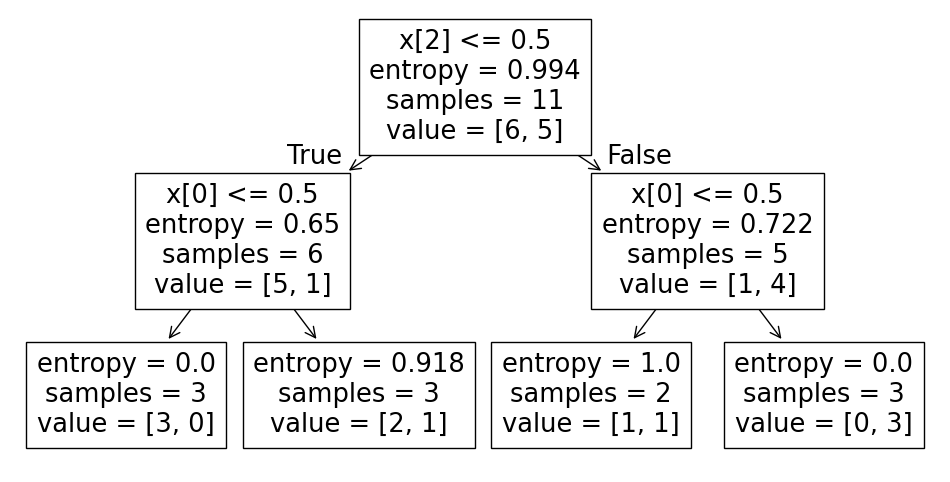

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("Infected_Data.csv")

# Separate features (X) and target (y)
X = data.drop(columns=['ID', 'Infected']) # Drop 'ID' and 'Infected' columns for features
y = data['Infected'] # Target column

# Convert categorical features and target to numerical codes
X = X.apply(lambda col: col.astype('category').cat.codes)
y = y.astype('category').cat.codes

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize Decision Tree Classifier with regularization parameters
clf = DecisionTreeClassifier(
    criterion="entropy", # Use entropy as the impurity measure
    max_depth=3,          # Limit the maximum depth of the tree to 3
    min_samples_leaf=2,   # Require at least 2 samples in a leaf node
    random_state=0        # Set random state for reproducibility
)
# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0,1])) # Print confusion matrix
print("Accuracy:", accuracy_score(y_test, y_pred)) # Print accuracy score

# Print the decision tree rules
print("\nDecision Tree Rules:\n")
print(export_text(clf, feature_names=list(X.columns))) # Export and print the decision tree rules

# Plot the decision tree
plt.figure(figsize=(12,6)) # Create a figure
plot_tree(clf) # Plot the tree
plt.show() # Display the plot

Cross-validation Accuracy Scores:
 [0.66666667 1.         1.         0.33333333 0.        ]
Mean Cross-validation Accuracy: 0.6

Confusion Matrix (Regularized Model):
 [[0 0]
 [0 3]]
Accuracy (Regularized Model): 1.0


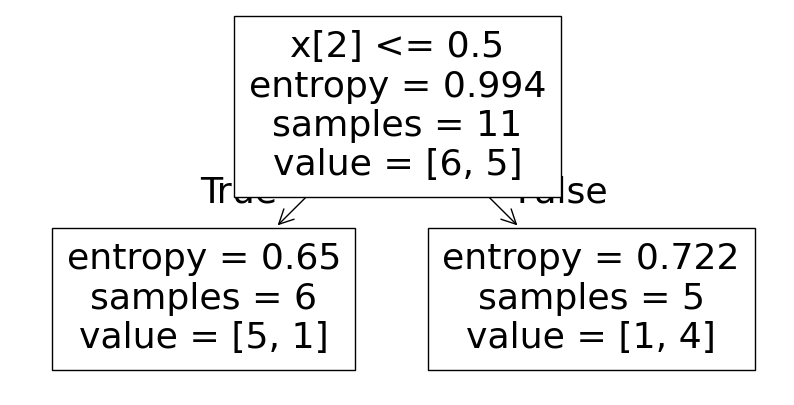

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score # Added cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
data = pd.read_csv("Infected_Data.csv")

# Separate features (X) and target (y)
X = data.drop(columns=['ID', 'Infected']) # Drop 'ID' and 'Infected' columns for features
y = data['Infected'] # Target column

# Convert categorical features and target to numerical codes (if not already done)
X = X.apply(lambda col: col.astype('category').cat.codes)
y = y.astype('category').cat.codes

# Adjust hyperparameters for regularization
clf_regularized = DecisionTreeClassifier(
    criterion="entropy", # Use entropy as the impurity measure
    max_depth=2,  # Reduced max_depth to 2 for more regularization
    min_samples_leaf=5, # Increased min_samples_leaf to 5 for more regularization
    random_state=0 # Set random state for reproducibility
)

# Evaluate using cross-validation
# Using 5 folds as an example
cv_scores = cross_val_score(clf_regularized, X, y, cv=5) # Perform 5-fold cross-validation

print("Cross-validation Accuracy Scores:\n", cv_scores) # Print cross-validation scores
print("Mean Cross-validation Accuracy:", cv_scores.mean()) # Print the mean cross-validation accuracy

# Optional: Train and evaluate on a single split with adjusted parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Split data
clf_regularized.fit(X_train, y_train) # Train the regularized classifier
y_pred_regularized = clf_regularized.predict(X_test) # Make predictions

print("\nConfusion Matrix (Regularized Model):\n", confusion_matrix(y_test, y_pred_regularized, labels=[0,1])) # Print confusion matrix
print("Accuracy (Regularized Model):", accuracy_score(y_test, y_pred_regularized)) # Print accuracy score

# Optional: Plot the regularized tree (if you train on a single split)
plt.figure(figsize=(10, 5)) # Create a figure
plot_tree(clf_regularized) # Plot the regularized tree
plt.show() # Display the plot


--- Manual Greedy Tree Build ---
Samples=14, Classes={0: 6, 1: 8}, Entropy=0.985
Split on 'Breathing Issues'
Branch Breathing Issues = 0:
  Samples=6, Classes={0: 5, 1: 1}, Entropy=0.65
  Split on 'Fever'
  Branch Fever = 0:
    Samples=3, Classes={0: 3}, Entropy=-0.0
    --> Leaf Node: Class 0
  Branch Fever = 1:
    Samples=3, Classes={0: 2, 1: 1}, Entropy=0.918
    Split on 'Cough'
    Branch Cough = 1:
      Samples=3, Classes={0: 2, 1: 1}, Entropy=0.918
      --> Leaf Node: Class 0
Branch Breathing Issues = 1:
  Samples=8, Classes={1: 7, 0: 1}, Entropy=0.544
  Split on 'Fever'
  Branch Fever = 0:
    Samples=3, Classes={1: 2, 0: 1}, Entropy=0.918
    Split on 'Cough'
    Branch Cough = 1:
      Samples=3, Classes={1: 2, 0: 1}, Entropy=0.918
      --> Leaf Node: Class 1
  Branch Fever = 1:
    Samples=5, Classes={1: 5}, Entropy=-0.0
    --> Leaf Node: Class 1

Cross-validation accuracy: 0.6

Confusion Matrix:
 [[0 0]
 [0 3]]
Test Accuracy: 1.0


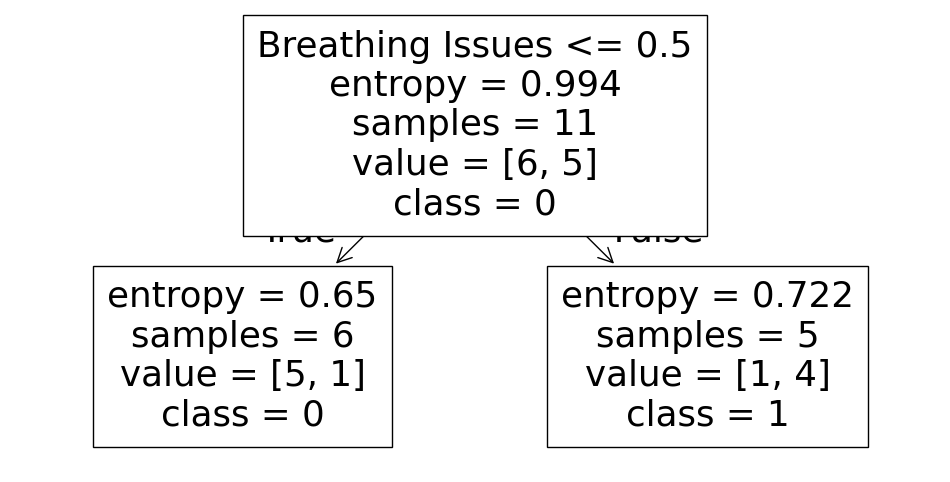

In [ ]:
# Easier code for Decision Tree from scratch and with scikit-learn
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load data
data = pd.read_csv("Infected_Data.csv")

# Separate features (X) and target (y)
X = data.drop(columns=['ID', 'Infected'])
y = data['Infected']

# Convert categorical to numeric codes
X = X.apply(lambda col: col.astype('category').cat.codes)
y = y.astype('category').cat.codes

# 2️⃣ Entropy function: Calculates the entropy of a set of labels.
def entropy(y):
    counts = Counter(y)
    probs = [c / len(y) for c in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

# 3️⃣ Best feature split (simple greedy approach): Finds the feature with the highest information gain.
def best_split(X, y):
    best_gain, best_feature = -1, None
    for feature in X.columns:
        parent_entropy = entropy(y)
        values = np.unique(X[feature])
        weighted_entropy = sum(
            (len(y[X[feature] == val]) / len(y)) * entropy(y[X[feature] == val])
            for val in values
        )
        gain = parent_entropy - weighted_entropy
        if gain > best_gain:
            best_gain, best_feature = gain, feature
    return best_feature

# 4️⃣ Simple recursive tree build (just prints structure): Builds a decision tree and prints its structure.
def build_tree(X, y, depth=0):
    print("  " * depth + f"Samples={len(y)}, Classes={dict(Counter(y))}, Entropy={round(entropy(y),3)}")
    if len(set(y)) == 1 or X.shape[1] == 0:
        print("  " * depth + f"--> Leaf Node: Class {Counter(y).most_common(1)[0][0]}")
        return

    feature = best_split(X, y)
    if feature is None:
        print("  " * depth + "--> No useful split, majority class assigned")
        return

    print("  " * depth + f"Split on '{feature}'")
    for val in np.unique(X[feature]):
        mask = X[feature] == val
        print("  " * depth + f"Branch {feature} = {val}:")
        build_tree(X[mask].drop(columns=[feature]), y[mask], depth+1)

print("\n--- Manual Greedy Tree Build ---")
build_tree(X, y)

# 5️⃣ Sklearn Decision Tree with regularization (to reduce overfitting): Trains a Decision Tree using scikit-learn with regularization.
clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=3,          # Limit depth
    min_samples_leaf=5,   # Minimum samples per leaf
    random_state=0
)

# Cross-validation accuracy: Evaluate the model using cross-validation.
cv_scores = cross_val_score(clf, X, y, cv=5)
print("\nCross-validation accuracy:", round(cv_scores.mean(), 3))

# Train/test split for final evaluation: Split data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[0, 1])) # Added labels for confusion matrix
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 3))

# 6️⃣ Plot final tree: Plot the trained decision tree.
plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=X.columns.tolist(), class_names=['0', '1']) # Added feature_names and class_names for better plot
plt.show()